In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('../data/raw/nytaxi2022.csv', usecols=[
     "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", 
     "RatecodeID", "PULocationID", "DOLocationID", "payment_type", 
     "extra", "total_amount"])
print(df.shape)
# df.head()

(39656098, 10)


## condition 1

In [11]:
# improvements

# locationid = (
#     df['PULocationID'].between(1, 265) &
#     df['DOLocationID'].between(1, 265))
# df = df[locationid] 写法 
# 比
# df = df[df['PULocationID'].between(1, 265)] 会创建一个新的 DataFrame 副本，把原 df 中符合条件的行复制出来，然后再赋值给 df。
# df = df[df['DOLocationID'].between(1, 265)] 又复制一次。在这个过程中，旧的df副本可能还没有被垃圾回收释放掉，于是内存里就同时存在两个大副本+原始 df，对几千万行的数据来说，很容易Kernel Crash
# 写法要好，但还是有复制

# 用drop或者query不会复制，但是query好像写不了判断整数 

In [12]:
# df = df.drop_duplicates()
df = df.dropna()

condition1 = (
    (df['passenger_count'] > 0) & (df['passenger_count'] <= 6) &
    (df['trip_distance'] > 0) & 
    (df['RatecodeID'] < 6) & (df['RatecodeID'] % 1 == 0) &        # (df['RatecodeID'] == 6).sum() output 111
    df['PULocationID'].between(1, 265) & (df['PULocationID'] % 1 == 0) &
    df['DOLocationID'].between(1, 265) & (df['DOLocationID'] % 1 == 0) &
    (df['extra'] >= 0) & (df['extra'] < 20) &
    (df["total_amount"] > 0) & (df["total_amount"] < 1000)
)

df.drop(df[~condition1].index, inplace=True)

df.shape

(36708331, 10)

## condition 2 (time)

In [13]:
# %H → 24h %I → 12h
df['tpep_pickup_datetime'] = pd.to_datetime(df["tpep_pickup_datetime"], format = "%m/%d/%Y %I:%M:%S %p", errors='coerce')
df['tpep_dropoff_datetime'] = pd.to_datetime(df["tpep_dropoff_datetime"], format = "%m/%d/%Y %I:%M:%S %p", errors='coerce')
df = df.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

# draw a plot
# df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
# df['dropoff_date'] = df['tpep_dropoff_datetime'].dt.date

# pickup_counts = df['pickup_date'].value_counts().sort_index()
# dropoff_counts = df['dropoff_date'].value_counts().sort_index()

# plt.figure(figsize=(12,5))
# plt.plot(pickup_counts.index, pickup_counts.values, label='Pickup')
# plt.plot(dropoff_counts.index, dropoff_counts.values, label='Dropoff')
# plt.xlabel('Date')
# plt.ylabel('Number of trips')
# plt.title('Daily trip counts')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

# df = df.drop(columns=['pickup_date', 'dropoff_date'])

/tmp/ipykernel_142448/2861027954.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


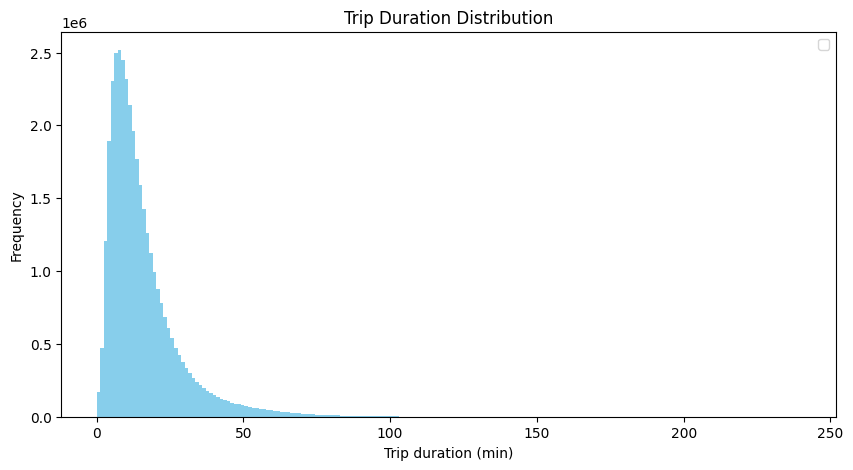

In [14]:
trip_dur_min = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
df['trip_dur_min'] = trip_dur_min

plt.figure(figsize=(10,5))
plt.hist(df['trip_dur_min'], bins=200, range=(0, 240), color='skyblue')
plt.xlabel("Trip duration (min)")
plt.ylabel("Frequency")
plt.title("Trip Duration Distribution")
plt.legend()
plt.show()

In [15]:
pickup_year = df['tpep_pickup_datetime'].dt.year
dropoff_year = df['tpep_dropoff_datetime'].dt.year

condition2 = (
    pickup_year.between(2020, 2024)) & (dropoff_year.between(2020, 2024) &
    (df['trip_dur_min'] > 0) & (df['trip_dur_min'] < 120)
)
df.drop(df[~condition2].index, inplace=True)

# Unix
arr_pick = df['tpep_pickup_datetime'].to_numpy(dtype='datetime64[ns]').view('i8')
arr_drop = df['tpep_dropoff_datetime'].to_numpy(dtype='datetime64[ns]').view('i8')
df['pickup_ts'] = (arr_pick // 10**9).astype('int64')
df['dropoff_ts'] = (arr_drop // 10**9).astype('int64')
df = df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

df.shape

(36652469, 11)

## condition 3

In [ ]:
# cols_to_check = ["passenger_count", 'trip_dur_min', 'pickup_ts', 'dropoff_ts', "trip_distance", "RatecodeID", "payment_type", "extra", "total_amount"]

# df[cols_to_check].plot(kind='box', subplots=True, layout=(3,3), figsize=(12,8))
# plt.tight_layout()
# plt.show()

: 

In [16]:
cols_to_check = ['trip_dur_min', "trip_distance", "total_amount", "extra"]

for col in cols_to_check:
    Q1 = df[col].quantile(0.2)
    Q3 = df[col].quantile(0.8)
    IQR = Q3 - Q1
    upper = Q3 + 30 * IQR   

    outlier_idx = df.index[df[col] > upper]   
    print(f"{col}: upper={upper:.2f}, will through away {len(outlier_idx)} extreme large values")
    df.drop(index=outlier_idx, inplace=True)


trip_dur_min: upper=487.12, will through away 0 extreme large values
trip_distance: upper=103.30, will through away 185 extreme large values
total_amount: upper=443.46, will through away 169 extreme large values
extra: upper=77.50, will through away 0 extreme large values


In [17]:
cols_to_check = ['trip_dur_min', "trip_distance", "total_amount", "extra"]

for col in cols_to_check:
    upper = df[col].quantile(0.99999)  
    outlier_idx = df.index[df[col] > upper]

    print(f"{col}: upper={upper:.2f}, will through away {len(outlier_idx)} extreme large values")
    df.drop(index=outlier_idx, inplace=True)

df.shape

trip_dur_min: upper=118.88, will through away 364 extreme large values
trip_distance: upper=75.20, will through away 367 extreme large values
total_amount: upper=358.60, will through away 366 extreme large values
extra: upper=11.25, will through away 16 extreme large values


(36651002, 11)

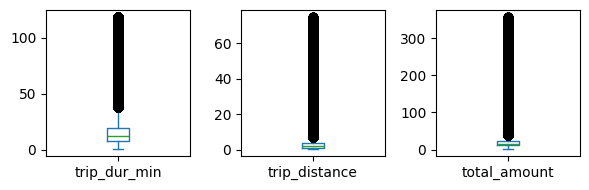

In [18]:
cols_to_check = ['trip_dur_min', "trip_distance", "total_amount"]

df[cols_to_check].plot(kind='box', subplots=True, layout=(1,3), figsize=(6,2))
plt.tight_layout()
plt.show()

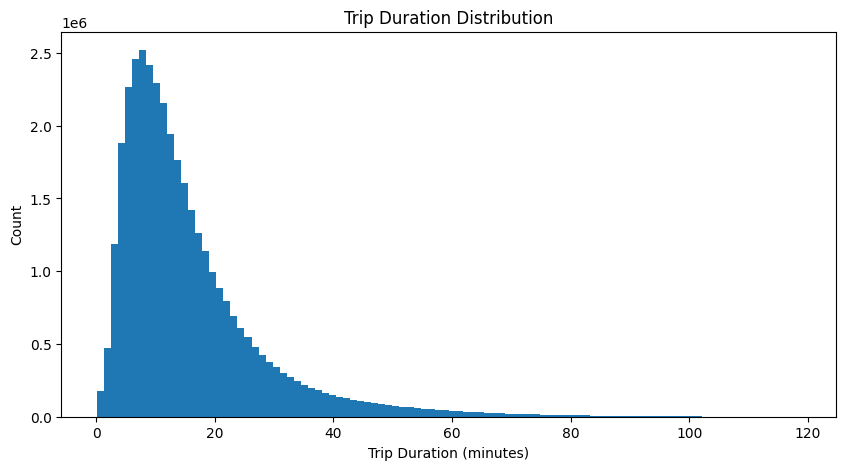

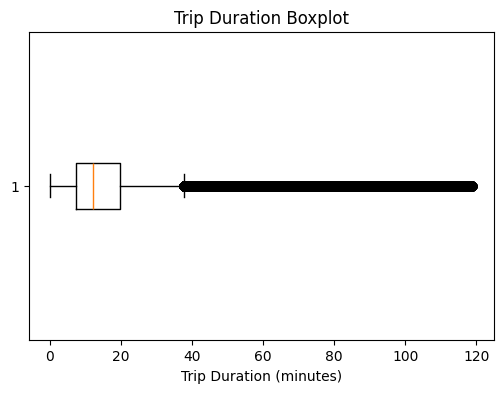

In [19]:
# Histogram
plt.figure(figsize=(10,5))
plt.hist(df['trip_dur_min'], bins=100)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Count')
plt.title('Trip Duration Distribution')
plt.show()

# Box plot
plt.figure(figsize=(6,4))
plt.boxplot(df['trip_dur_min'], vert=False)
plt.xlabel('Trip Duration (minutes)')
plt.title('Trip Duration Boxplot')
plt.show()

## one-hot & normalize

In [20]:
from pandas.api.types import CategoricalDtype

df['RatecodeID'] = df['RatecodeID'].astype(CategoricalDtype(categories=[1,2,3,4,5], ordered=False))
df['payment_type'] = df['payment_type'].astype(CategoricalDtype(categories=[1,2,3,4], ordered=False))

df = pd.get_dummies(df,
                    columns=['RatecodeID', 'payment_type'], 
                    prefix=['Ratecode', 'paytype'],
                    dummy_na=False)
df.shape

(36651002, 18)

In [21]:
num_cols = ['passenger_count','trip_distance','extra','pickup_ts','dropoff_ts','trip_dur_min','PULocationID','DOLocationID']
for col in num_cols:
    col_min = df[col].min()
    col_max = df[col].max()
    if col_max > col_min:
        df[col] = (df[col] - col_min) / (col_max - col_min)

## move total_amount to the last column

In [22]:
cols = [c for c in df.columns if c != "total_amount"] + ["total_amount"]
df = df[cols]

In [23]:
df.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,extra,trip_dur_min,pickup_ts,dropoff_ts,Ratecode_1,Ratecode_2,Ratecode_3,Ratecode_4,Ratecode_5,paytype_1,paytype_2,paytype_3,paytype_4,total_amount
0,0.2,0.050439,0.534091,0.890152,0.266667,0.149748,0.000470,0.000495,True,False,False,False,False,True,False,False,False,21.95
1,0.0,0.027815,0.890152,0.155303,0.044444,0.070527,0.000466,0.000473,True,False,False,False,False,True,False,False,False,13.30
2,0.0,0.012776,0.625000,0.625000,0.044444,0.075294,0.000504,0.000512,True,False,False,False,False,True,False,False,False,10.56
3,0.0,0.014373,0.428030,0.253788,0.044444,0.084268,0.000450,0.000461,True,False,False,False,False,False,True,False,False,11.80
4,0.0,0.057093,0.253788,0.613636,0.044444,0.315620,0.000472,0.000535,True,False,False,False,False,True,False,False,False,30.30


## save as .parquet

In [24]:
import os

os.makedirs("../data/processed", exist_ok=True)

# 保存为 parquet
df.to_parquet("../data/processed/dataall.parquet", index=False)
print("Saved to ../data/processed/dataall.parquet")



Saved to ../data/processed/dataall.parquet


## check

In [25]:
import pyarrow.parquet as pq

# 读 parquet 文件的元信息
parquet_file = pq.ParquetFile("../data/processed/dataall.parquet")

print("Number of row groups:", parquet_file.num_row_groups)

# 查看每个 row group 的大小和行数
for i in range(parquet_file.num_row_groups):
    rg_meta = parquet_file.metadata.row_group(i)
    print(f"Row Group {i}: {rg_meta.num_rows} rows, {rg_meta.total_byte_size/1024/1024:.2f} MB")


Number of row groups: 35
Row Group 0: 1048576 rows, 24.92 MB
Row Group 1: 1048576 rows, 24.76 MB
Row Group 2: 1048576 rows, 24.72 MB
Row Group 3: 1048576 rows, 24.05 MB
Row Group 4: 1048576 rows, 24.51 MB
Row Group 5: 1048576 rows, 24.00 MB
Row Group 6: 1048576 rows, 24.26 MB
Row Group 7: 1048576 rows, 24.00 MB
Row Group 8: 1048576 rows, 24.46 MB
Row Group 9: 1048576 rows, 23.96 MB
Row Group 10: 1048576 rows, 24.29 MB
Row Group 11: 1048576 rows, 24.43 MB
Row Group 12: 1048576 rows, 24.08 MB
Row Group 13: 1048576 rows, 24.09 MB
Row Group 14: 1048576 rows, 24.13 MB
Row Group 15: 1048576 rows, 24.02 MB
Row Group 16: 1048576 rows, 24.17 MB
Row Group 17: 1048576 rows, 24.51 MB
Row Group 18: 1048576 rows, 24.46 MB
Row Group 19: 1048576 rows, 24.25 MB
Row Group 20: 1048576 rows, 24.48 MB
Row Group 21: 1048576 rows, 24.43 MB
Row Group 22: 1048576 rows, 24.66 MB
Row Group 23: 1048576 rows, 24.42 MB
Row Group 24: 1048576 rows, 24.49 MB
Row Group 25: 1048576 rows, 24.36 MB
Row Group 26: 1048576 r

In [ ]:
parquet_file.read_row_group(1).to_pandas().head()

,passenger_count,trip_distance,PULocationID,DOLocationID,extra,trip_dur_min,pickup_ts,dropoff_ts,Ratecode_1,Ratecode_2,Ratecode_3,Ratecode_4,Ratecode_5,paytype_1,paytype_2,paytype_3,paytype_4,total_amount
0,0.4,0.012510,0.295455,0.844697,0.000000,0.060712,0.040978,0.040981,True,False,False,False,False,True,False,False,False,11.76
1,0.4,0.011845,0.939394,0.337121,0.222222,0.041223,0.040921,0.040920,True,False,False,False,False,True,False,False,False,10.12
2,0.0,0.011845,0.939394,0.424242,0.222222,0.046691,0.040943,0.040943,True,False,False,False,False,False,True,False,False,8.80
3,0.0,0.014506,0.401515,0.295455,0.222222,0.073191,0.040993,0.040999,True,False,False,False,False,True,False,False,False,11.30
4,0.2,0.020096,0.992424,0.863636,0.000000,0.057207,0.040948,0.040950,True,False,False,False,False,True,False,False,False,12.36


: 

In [ ]:
df = pd.read_parquet("../data/processed/dataall.parquet")  
print(df["total_amount"].min())  
print(df["total_amount"].max())  
print(df["total_amount"].mean())  
print(df["total_amount"].std())  

0.04
375.05
21.42937336026941
16.696426233554053


: 